In [220]:
import pandas as pd
import numpy as np
from numpy import *
import random
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
#from sklearn import decomposition
%matplotlib inline

## Preprocessing data

- In this first part we are going to preproces our data in order to perform, later, the analysis. In particular, we are going to define 4 functions that we need:<br>
     - f_organize = that transposes and rolls the df
     - function_name = that add the names to the columns
     - pca_function = that performes the PCA in order to reduce the namber of features.

In [ ]:
#define a function that transposes and rolls the data

def f_organize(df,n,z):# n = number of rolls; z=lnly for first iteration in order to get the first 3 columns.
        
    df1 = df.iloc[:,3:]
    df1 = df1.transpose()
    df1 = df1.rolling(n).mean()
    df1 = df1.fillna(method='bfill') #'ffill'= stands for 'forward fill'
    df1 = df1.fillna(method='ffill') # 'bfill' = stands for 'backwards fill'
    df1 = df1.transpose()
    if z == 0:#we need the first 3 columns only from one df and not from all of them.
        df_info = df.iloc[:,0:3]
        df2 = pd.concat([df_info, df1], axis=1, sort=False)
    else:
        df2 = df1 
    return(df2)

In [ ]:
def function_name(df,d):
    labels1 = ['gesture','participanNr','sampleNr']
    labels=['accelleration_value_'+str(m) for m in range(1,1273)]
    if d == 0:
        labels=labels[0:424]#labels from 1 up to 424
        for p in range(3):
            labels.insert(p, labels1[p])
        df.columns = labels
    elif d == 1:
        labels=labels[424:848] # labels from 425 upto 848
        for r in range(3):
            labels.insert(r,labels1[r])
        df.columns = labels
    else:
        labels=labels[848:] # labels from 849 upto 1272
        for v in range(3):
            labels.insert(v,labels1[v])
        df.columns = labels
    return(df)

In [ ]:
xyz=['x','y','z']
df_list=[] # empty list where we are about to store the three .csv files
for d in range(3):
    read_df = pd.read_csv('raw_data_wear_'+str(xyz[d])+'.csv', header=None) # we read the files
    read_df = function_name(read_df,d)
    df_list.append(f_organize(read_df,30,d)) # we apply our function to roll and clean the .csv

df = pd.concat(df_list, axis = 1, sort=False) # we store the three files into one DataFrame.

In [ ]:
# from 50Hz to 25Hz
for n in range(1,1273):
    if n%2==0:
        df.drop('accelleration_value_'+str(n), axis=1, inplace=True)
    else:
        continue        

In [ ]:
df.to_csv('gestures.csv',index = None, header=True, encoding='utf-8')

## pca
- here we are going to define the function that we'll call to perform the PCA in order to reduce the namber of features that have to be taken into account.

In [88]:
df = pd.read_csv('gestures.csv')

In [ ]:
def pca_function(Data_Frame, components, position):
    movements = {'left':1,'right':2, 'up':3, 'down':4, 'square':5, 'triangle':6, 'circleCw':7, 'circleCcw':8}
    
    pca = PCA(n_components=components)#we decide the number of components
    pca.fit(Data_Frame.iloc[:,position:])
    #we apply pca to the data (excluding the 'Label' column)
    pca_data = pca.transform(Data_Frame.iloc[:,position:])
    data_target=Data_Frame.iloc[:,0:position]#series of all the labels
    pca_dataframe = pd.DataFrame(pca_data)
    mergedDf = data_target.merge(pca_dataframe, left_index=True, right_index=True)
    mergedDf.gesture = [movements[m] for m in mergedDf.gesture]#from string to integer. We need for ML algorithms
    
    return(mergedDf)

In [ ]:
# new_df = pca_function(df, 50, 3)
# new_df.shape

## Hyperparameter tuning

In [ ]:
classifiers = {
    'knn':KNeighborsClassifier(),
    'dtc': DecisionTreeClassifier(),
    'svm': SVC(),
    'rf': RandomForestClassifier()
              }
paramiters = {
    'knn':{'n_neighbors':[int(x) for x in np.linspace(1, 200, num = 5)], 'weights':['uniform','distance']},
    
    'dtc':{'max_depth':[5,10], 'max_features':[int(x) for x in np.linspace(1, 45, num = 5)]},
    
    'svm': [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2,1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
    
    'rf': {
        'n_estimators': [int(x) for x in np.linspace(10,500, num = 3)],
        'max_depth': [int(x) for x in np.linspace(10, 100, 3)],
        'bootstrap': [True,False]
        
    }
          }

In [91]:
#classifiers = {'knn':KNeighborsClassifier(), 'dtc': DecisionTreeClassifier()}
#paramiters = {
#    'knn':{'n_neighbors':[int(x) for x in np.linspace(1, 200, num = 2)], 'weights':['distance']},    
#    'dtc':{'max_depth':[5,10], 'max_features':[int(x) for x in np.linspace(1, 20, num = 5)]}
#}

In [ ]:
gs_scores = {}
gs_paramiters = {}
gs_estimators = {}
for k in classifiers.keys():
    grid = GridSearchCV(
        classifiers[k], 
        paramiters[k], 
        cv = KFold(n_splits=10, random_state=25, shuffle=True), 
        scoring = 'accuracy')
    
    grid.fit(X_train,y_train)
    gs_scores[k] = grid.grid_scores_
    gs_paramiters[k] = grid.best_params_
    gs_estimators[k] = grid.best_estimator_

## Prediction and Accuracy

- Now, let's make the prediction by using the models setting the hyperparamiters previously tuned and let's looking for the best predictive model for the gesture recognition challenge. 
- In order to do that we'll perform the analysis 10 times, chaningin every time the PCA. 

In [143]:
mean_results = defaultdict(list) # dictionary where we are going to store the accuracy for each model
confusion_matrices = defaultdict(list) # we store the confusion matrix that later we'll plot
pca_list = [x*10 for x in range(1,11)] # list of PCAs
classifier_dict = {'knn':KNeighborsClassifier(n_neighbors = 1, weights = 'distance'),
                   'svm': SVC(C = 10, gamma = 0.001, kernel = 'rbf'),
                   'dtc': DecisionTreeClassifier(max_depth = 10, max_features = 23),
                   'rf': RandomForestClassifier(bootstrap = False, max_depth = 100, n_estimators = 500),
                   'gnb': GaussianNB()
                  }

for n in pca_list:
    
    pca_df = pca_function(df, n, 3) # we apply the PCA
    X = pca_df.iloc[:,3:] # we take only the values
    y = pca_df.iloc[:,0] # we take the label
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) # we split the df in train(80%) and test(20%) set.
    
    for k in classifier_dict.keys(): # now we call, one by one, all the models
        
        if k == 'dtc' and n < 50:
            model_selected = DecisionTreeClassifier()
        else:
            model_selected = classifier_dict[k] # we select the model
        
        model_selected.fit(X_train,y_train) # we fit the model with the train set
        y_prediction = model_selected.predict(X_test) # we make the prediction
             
        mean_results[k].append(accuracy_score(y_test,y_prediction))
        confusion_matrices[k].append(confusion_matrix(y_test, y_prediction))
        

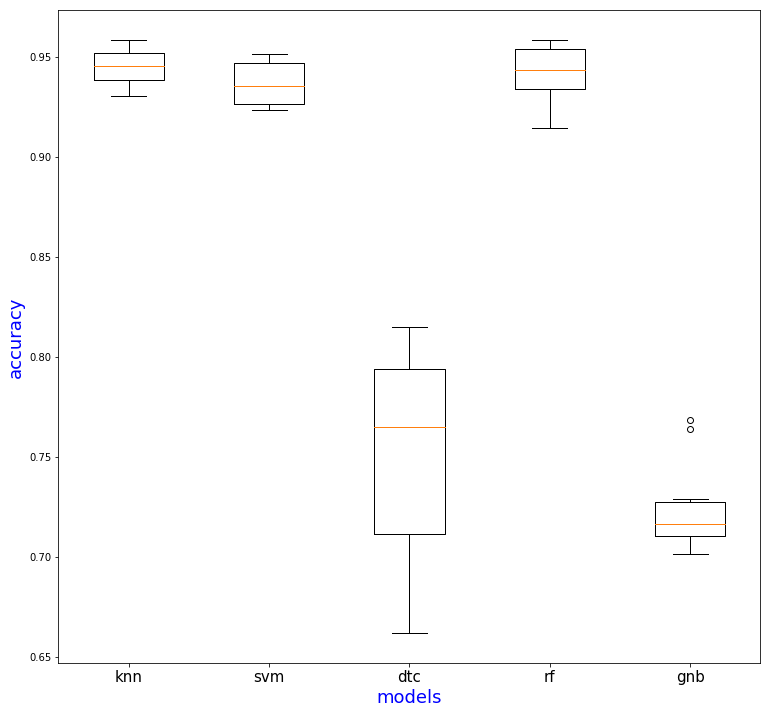

In [300]:
labels, data = [*zip(*mean_results.items())]  # 'transpose' items to parallel key, value lists
labels, data = mean_results.keys(), mean_results.values()

plt.figure(figsize = (15,12))
plt.subplots_adjust(left=0.25)
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels, fontsize = 15)
plt.xlabel('models', fontsize=18).set_color("Blue")
plt.ylabel('accuracy', fontsize=18).set_color("Blue")

#plt.savefig('models_accuracies.png')
plt.show()

In [349]:
best_model = {}
for k,v in mean_results.items():
    best_model[k]=v.index(max(v))



for k,v in mean_results.items():
    print (k, [round(x,4) for x in v])
print(best_model)

knn [0.9306, 0.9444, 0.9583, 0.9375, 0.9375, 0.9421, 0.9468, 0.9468, 0.9537, 0.956]
svm [0.9236, 0.9236, 0.9514, 0.9375, 0.9329, 0.9491, 0.9282, 0.9259, 0.9491, 0.9398]
dtc [0.794, 0.794, 0.8148, 0.8102, 0.7616, 0.7685, 0.6991, 0.7361, 0.7037, 0.662]
rf [0.9144, 0.9306, 0.9421, 0.9329, 0.9375, 0.9537, 0.9444, 0.9537, 0.9583, 0.9583]
gnb [0.7222, 0.7639, 0.7685, 0.7292, 0.7106, 0.7199, 0.7106, 0.7014, 0.7106, 0.713]
{'knn': 2, 'svm': 2, 'dtc': 2, 'rf': 8, 'gnb': 2}


In [351]:
best_model_PCA_30 = {}
for k in mean_results.keys():
    best_model_PCA_30[k] = 2



for k,v in mean_results.items():
    print (k, [round(x,4) for x in v])
print(best_model_PCA_30)

knn [0.9306, 0.9444, 0.9583, 0.9375, 0.9375, 0.9421, 0.9468, 0.9468, 0.9537, 0.956]
svm [0.9236, 0.9236, 0.9514, 0.9375, 0.9329, 0.9491, 0.9282, 0.9259, 0.9491, 0.9398]
dtc [0.794, 0.794, 0.8148, 0.8102, 0.7616, 0.7685, 0.6991, 0.7361, 0.7037, 0.662]
rf [0.9144, 0.9306, 0.9421, 0.9329, 0.9375, 0.9537, 0.9444, 0.9537, 0.9583, 0.9583]
gnb [0.7222, 0.7639, 0.7685, 0.7292, 0.7106, 0.7199, 0.7106, 0.7014, 0.7106, 0.713]
{'knn': 2, 'svm': 2, 'dtc': 2, 'rf': 2, 'gnb': 2}


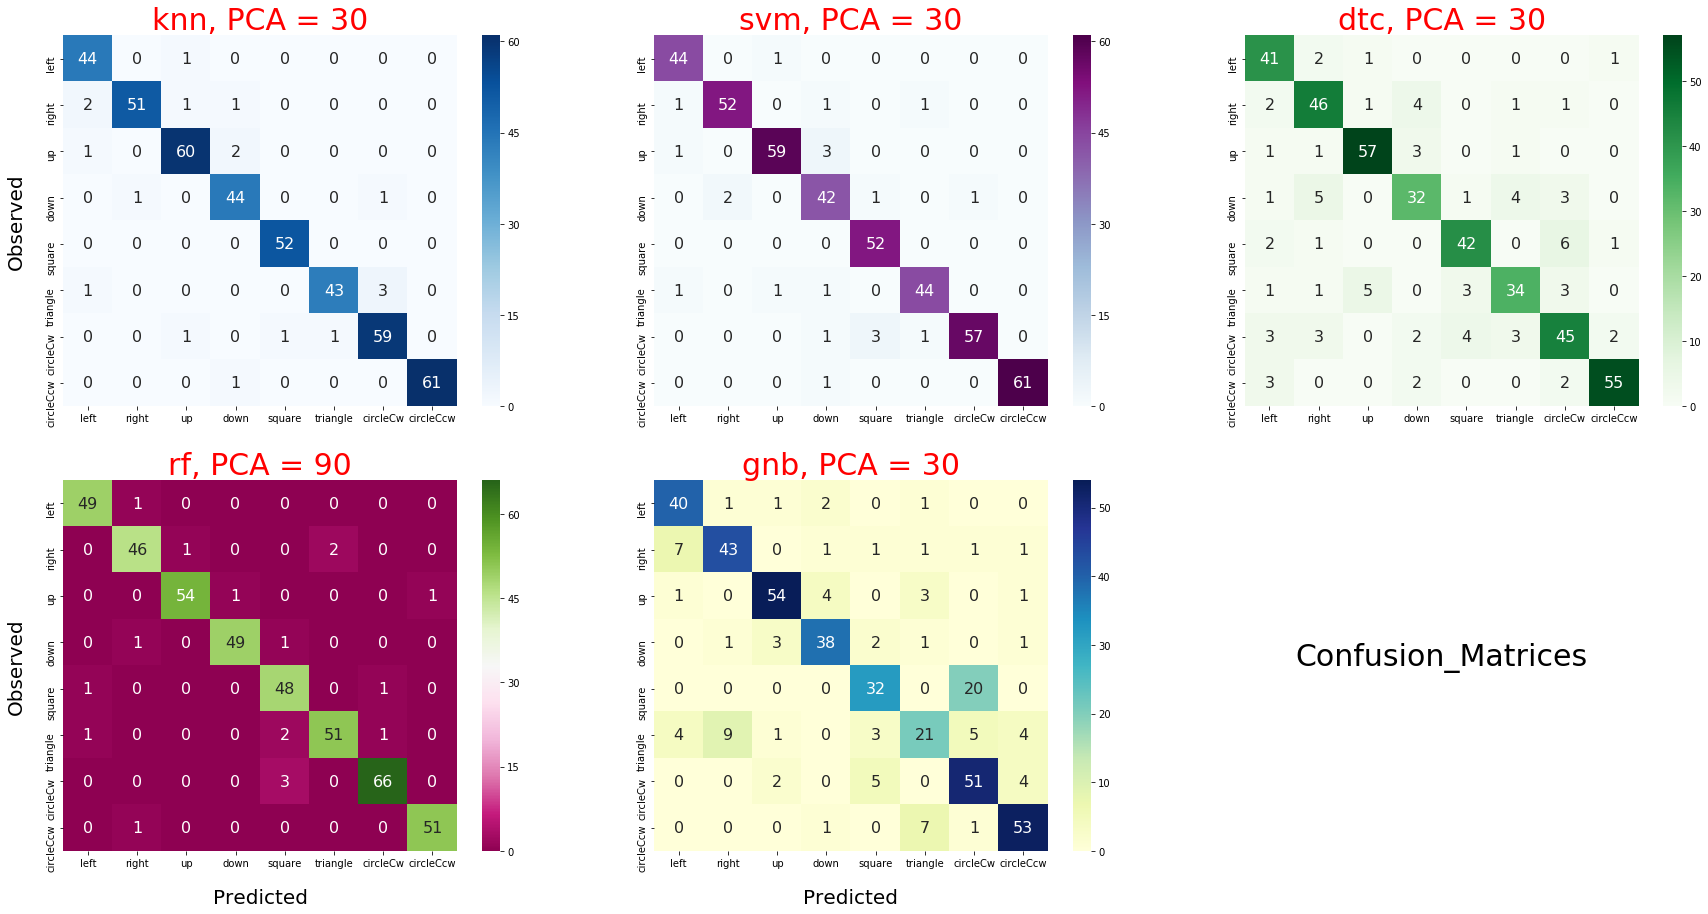

In [357]:
colors_map = ['Blues', 'BuPu', 'Greens', 'PiYG', 'YlGnBu']
movements = ['left','right', 'up', 'down', 'square', 'triangle', 'circleCw', 'circleCcw']

fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
#ax5 = fig.add_subplot(236)
# We use ax parameter to tell seaborn which subplot to use for this plot
sns.heatmap(confusion_matrices['knn'][2], cmap= 'Blues', annot=True,annot_kws={"size": 16}, ax=ax1)

sns.heatmap(confusion_matrices['svm'][2], cmap= 'BuPu', annot=True,annot_kws={"size": 16}, ax=ax2)
sns.heatmap(confusion_matrices['dtc'][2], cmap= 'Greens', annot=True,annot_kws={"size": 16}, ax=ax3)
sns.heatmap(confusion_matrices['rf'][8], cmap= 'PiYG', annot=True,annot_kws={"size": 16}, ax=ax4)
sns.heatmap(confusion_matrices['gnb'][2], cmap= 'YlGnBu', annot=True,annot_kws={"size": 16}, ax=ax5)
plt.text(16, 4, 'Confusion_Matrices', fontsize=30, ha='center')
labels_list=[ax1,ax2,ax3,ax4,ax5]
for n, (k,v) in enumerate(best_model.items()):
    #labels_list[n].set(xlabel='Predicted', ylabel='Observed')
    labels_list[n].set_title(k+str(', PCA = '+str((v+1)*10)), color='Red', fontsize=30)
    #labels_list[n].xaxis.labelpad = 20
    #labels_list[n].yaxis.labelpad = 20
    #labels_list[n].yaxis.label.set_size(20)
    #labels_list[n].xaxis.label.set_size(20)
    labels_list[n].set_xticklabels(movements)
    labels_list[n].set_yticklabels(movements)
ax1.set(ylabel='Observed')
ax1.yaxis.labelpad = 20
ax1.yaxis.label.set_size(20)
ax4.set(xlabel='Predicted', ylabel='Observed')
ax4.yaxis.labelpad = 20
ax4.xaxis.labelpad = 20
ax4.yaxis.label.set_size(20)
ax4.xaxis.label.set_size(20)
ax5.set(xlabel='Predicted')
ax5.xaxis.labelpad = 20
ax5.xaxis.label.set_size(20)
plt.savefig('confusions_matrices2_MAX_PCA.png')

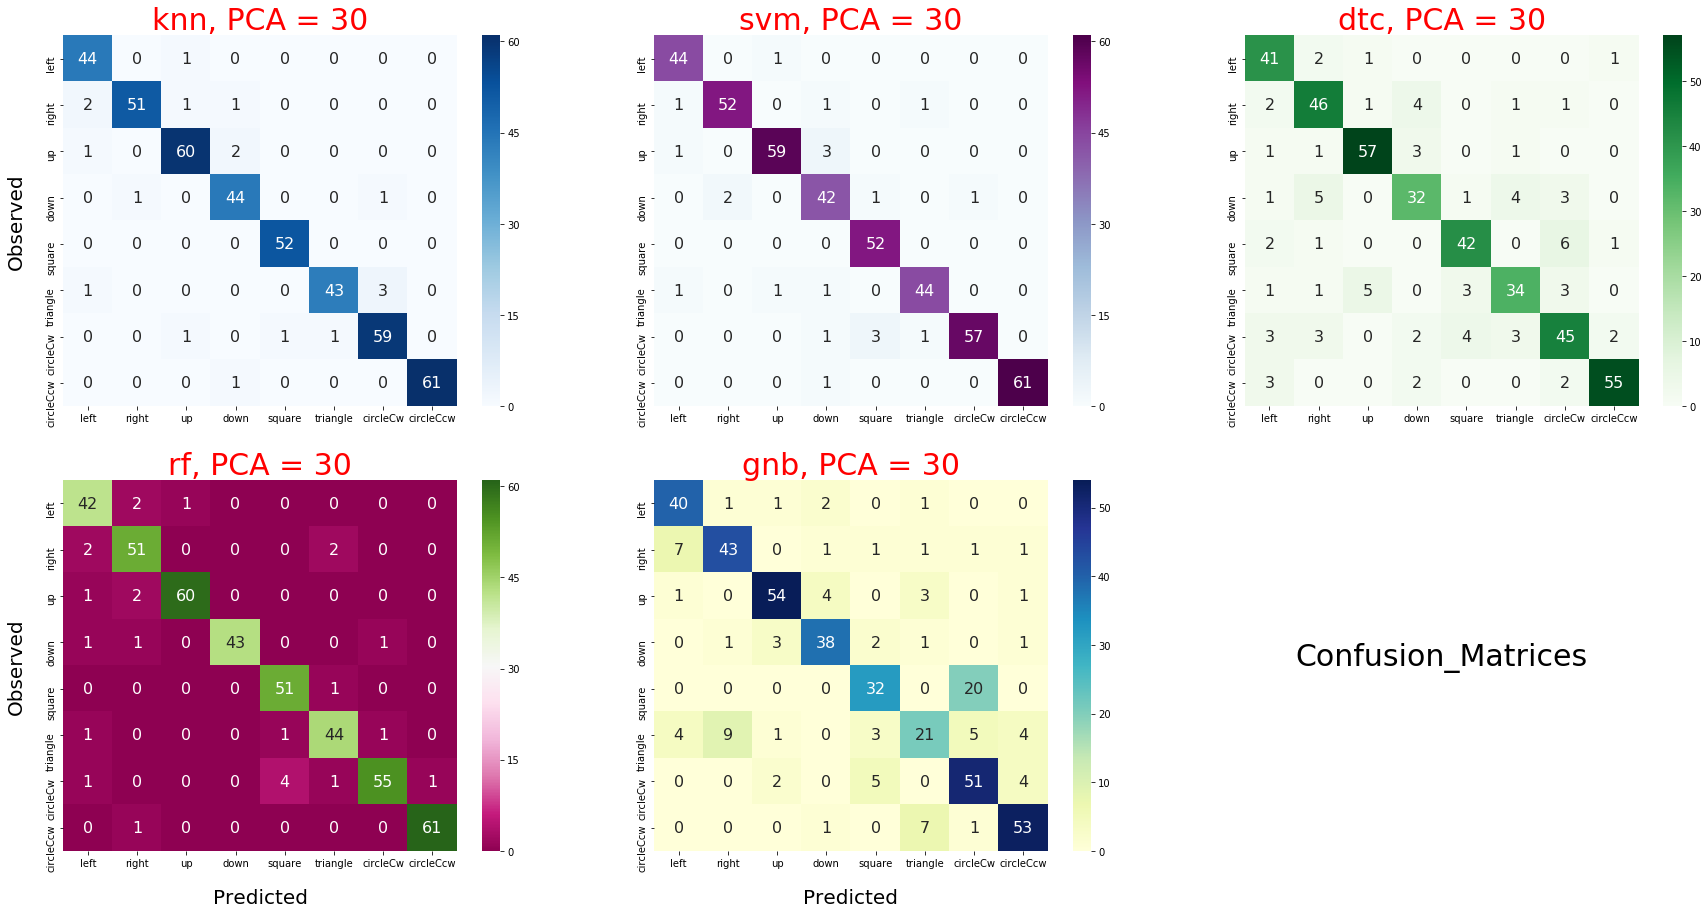

In [358]:
colors_map = ['Blues', 'BuPu', 'Greens', 'PiYG', 'YlGnBu']
movements = ['left','right', 'up', 'down', 'square', 'triangle', 'circleCw', 'circleCcw']

fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
#ax5 = fig.add_subplot(236)
# We use ax parameter to tell seaborn which subplot to use for this plot
sns.heatmap(confusion_matrices['knn'][2], cmap= 'Blues', annot=True,annot_kws={"size": 16}, ax=ax1)

sns.heatmap(confusion_matrices['svm'][2], cmap= 'BuPu', annot=True,annot_kws={"size": 16}, ax=ax2)
sns.heatmap(confusion_matrices['dtc'][2], cmap= 'Greens', annot=True,annot_kws={"size": 16}, ax=ax3)
sns.heatmap(confusion_matrices['rf'][2], cmap= 'PiYG', annot=True,annot_kws={"size": 16}, ax=ax4)
sns.heatmap(confusion_matrices['gnb'][2], cmap= 'YlGnBu', annot=True,annot_kws={"size": 16}, ax=ax5)
plt.text(16, 4, 'Confusion_Matrices', fontsize=30, ha='center')
labels_list=[ax1,ax2,ax3,ax4,ax5]
for n, (k,v) in enumerate(best_model_PCA_30.items()):
    #labels_list[n].set(xlabel='Predicted', ylabel='Observed')
    labels_list[n].set_title(k+str(', PCA = '+str((v+1)*10)), color='Red', fontsize=30)
    #labels_list[n].xaxis.labelpad = 20
    #labels_list[n].yaxis.labelpad = 20
    #labels_list[n].yaxis.label.set_size(20)
    #labels_list[n].xaxis.label.set_size(20)
    labels_list[n].set_xticklabels(movements)
    labels_list[n].set_yticklabels(movements)
ax1.set(ylabel='Observed')
ax1.yaxis.labelpad = 20
ax1.yaxis.label.set_size(20)
ax4.set(xlabel='Predicted', ylabel='Observed')
ax4.yaxis.labelpad = 20
ax4.xaxis.labelpad = 20
ax4.yaxis.label.set_size(20)
ax4.xaxis.label.set_size(20)
ax5.set(xlabel='Predicted')
ax5.xaxis.labelpad = 20
ax5.xaxis.label.set_size(20)
plt.savefig('confusions_matrices2_PCA_30.png')

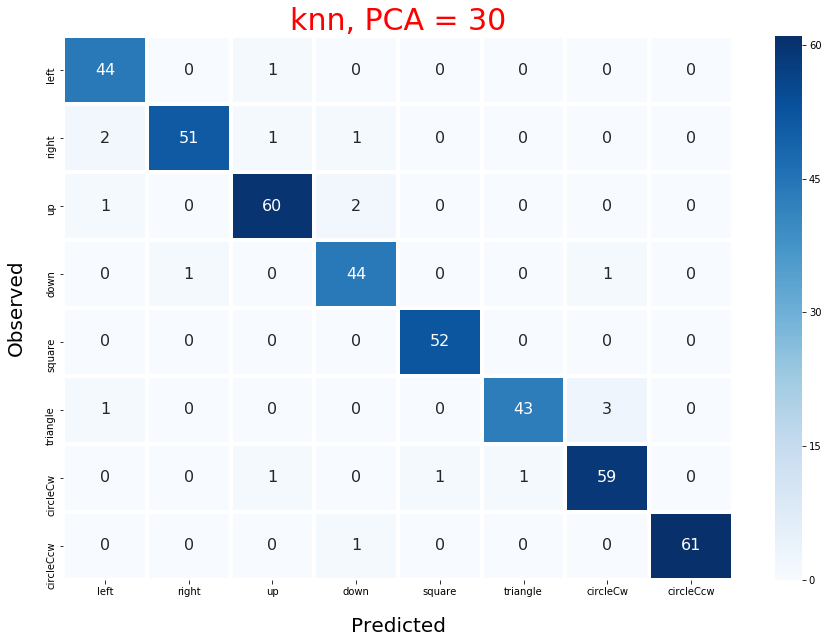

In [385]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
sns.heatmap(confusion_matrices['knn'][2], xticklabels = movements, yticklabels = movements, cmap= 'Blues', annot=True, annot_kws={"size": 16}, linewidth=3, ax =ax);
ax.set_title('knn, PCA = 30', color='Red', fontsize=30)
ax.set(xlabel='Predicted', ylabel='Observed')
ax.yaxis.labelpad = 20
ax.xaxis.labelpad = 20
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig('knn_matrix_PCA_30.png')

## Storage
- storing the dictionaries with all the accuracies based on the number of PCA
- we are going to store all the best matrixes got from the dictionary above

In [ ]:
with open('mean_results.json') as json_file:
    data = json.load(json_file)

In [ ]:
with open('mean_results.json', 'w') as outfile:
    json.dump(mean_results, outfile)

In [319]:
# for MAX PCA
for k,v in best_model.items():
    
    with open(k+'.txt', 'w') as f:
        csv.writer(f, delimiter=' ').writerows(confusion_matrices[k][v])

In [359]:
data = loadtxt("dtc.txt") 

In [361]:
# for PCA = 30
for k,v in best_model_PCA_30.items():
    
    with open(k+'PCA_30.txt', 'w') as f:
        csv.writer(f, delimiter=' ').writerows(confusion_matrices[k][v])